In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [102]:
exact_column = "exact_data_based"
eps = 0.000001

import utils
input = utils.load_data([
    "../results/synthetic/1000/set5/",
    "../results/synthetic/1000/set4_aggregated/",
], "_x80_*")

data = utils.merge_exact(input, "exact_data_based")
data = data[data.selector & (~data.identifiable)]

# plot PNS of less EMCC agains bounds of 80 runs

In [103]:
l = data.pns_l_x
u = data.pns_u_x

for n in range(80): # 0-79
    cols = [f"pns_{i}" for i in range(n+1)] # 0-[0-1]-[0-79]
    a = data[cols].min(axis=1)
    b = data[cols].max(axis=1)
    
    data[f'error_r_{n+1}'] = np.sqrt(((l - a) ** 2 + (u - b) ** 2) / 2) / (u - l)

data["L"] = u - l

In [104]:
ns = [10, 20, 30, 40, 50, 60, 70]

nsname=str.join("-", np.array(ns).astype(str))
err_cols = [f'error_r_{i}' for i in ns]

In [116]:
a = data.pns_l_x
b = data.pns_u_x
L = b - a
n = 80
for eps in [0.001, 0.005, 0.0075, 0.01, 0.05, 0.075, 0.1 ]:
    data[f'p_unif_{eps}'] = (
        (
            1 + (1 + 2*eps)**(2 - n) - 2 * (1 + eps) ** (2-n)
        ) / (
            (1 - L ** (n - 2)) - (n - 2) * (1 - L) * L ** (n - 2)
        )
    )



In [117]:
data[f"p_unif_0.001"].describe()

count    666.000000
mean       0.006932
std        0.021283
min        0.005692
25%        0.005692
50%        0.005692
75%        0.005692
max        0.549799
Name: p_unif_0.001, dtype: float64

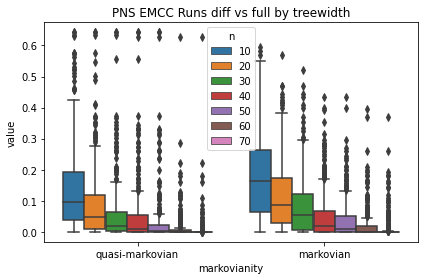

In [106]:
d = data


dta = pd.melt(d[err_cols + ["markovianity"]], id_vars="markovianity")
dta["n"]=dta.variable.str.split("_").str[-1].astype(int)
sns.boxplot(x="markovianity", hue="n", y="value", data=dta, hue_order=ns)
plt.title("PNS EMCC Runs diff vs full by treewidth")
plt.tight_layout()
plt.savefig(f"PNS_runs_all_{nsname}.png")
plt.show()


# save boxplots
with np.printoptions(linewidth=100000):
    utils.boxplots(dta, "value", "markovianity", "n").to_csv(f"paper_data/boxplot_RRMSE.csv")

# now by the range of the interval

In [107]:
data.L.describe()

count    6.660000e+02
mean     3.690847e-01
std      3.060551e-01
min      7.520155e-08
25%      1.026708e-01
50%      2.687492e-01
75%      6.369577e-01
max      9.980746e-01
Name: L, dtype: float64

In [108]:
data['error_diff'] = np.sqrt(((data.pns_l_x - data.pns_l_y) ** 2 + (data.pns_u_x - data.pns_u_y) ** 2) / 2) / (data.pns_u_x - data.pns_l_x)

data_ps1_0 = data[data['index'] == 2].copy() 
data_ps1_1 = data[data['index'] == 10].copy()
data_ps1_x = data[data['index'] == 1]
data_mid = data[(data['index'] > 2) & (data['index'] != 10)].copy()

data_mid['ps1_disc'] = pd.cut(data_mid.ps1, bins=5)
data_ps1_0['ps1_disc'] = pd.Interval(0,0)
data_ps1_1['ps1_disc'] = pd.Interval(1,1)

data = pd.concat((data_ps1_0, data_mid, data_ps1_1))
#data['ps1_disc'] = data['ps1_disc'].astype(str)

cols = np.msort(np.array([[i.left, i] for i in data.ps1_disc.unique()]))[:,1]

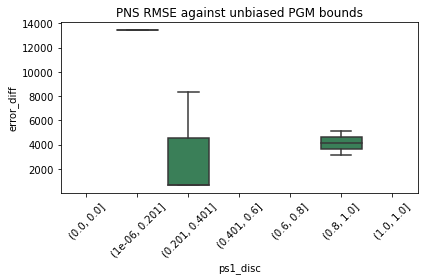

In [109]:
d = data[data.L < 0.00001]
sns.boxplot(x="ps1_disc", y="error_diff", data=d, order=cols, color="seagreen")
plt.title("PNS RMSE against unbiased PGM bounds")
plt.xticks(rotation = 45)
plt.tight_layout()
#plt.savefig("plot_data/PNS_vs_PGM_by_ps1.png")


# interesting cols

p_unif: p computed on 80 point using the old p formula

ps1_disc: discretization (7 values: 0-0, 5 discretizations of ps1 and 1-1)

markovianity

error_diff : RRMSE a* b* vs pns_pgm bounds (on unbiased data)

error_r_[1-80]: difference between subset of pns with all 80 pns. error_r_80 == 1.0

L: b* - a*



In [110]:
data.to_csv("paper_data/data.csv")